In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.utils import resample, shuffle
from scipy.sparse import vstack

import warnings
warnings.filterwarnings('ignore')


In [ ]:
df = pd.read_csv('dataset/amazon-fine-food-reviews/Reviews.csv')
print(f"Dataset shape: {df.shape}")
df.head()


Dataset shape: (568454, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
# Cell 3: Basic preprocessing
# For simplicity, we'll focus on the 'Text' column for reviews and 'Score' for sentiment

# Drop rows with missing Text or Score
df = df.dropna(subset=['Text', 'Score'])

# For classification, convert Score into binary sentiment:
# Positive (Score >=4) = 1, Negative (Score <=2) = 0, drop neutral (Score=3)

# df = df[df['Score'] != 3]
# df['Sentiment'] = df['Score'].apply(lambda x: 1 if x >= 4 else 0)

# print(f"After filtering, dataset shape: {df.shape}")
# df[['Text', 'Score', 'Sentiment']].head()


In [ ]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)

X = vectorizer.fit_transform(df['Text'])
y = df['Score']

print(f"Feature matrix shape: {X.shape}")


Feature matrix shape: (568454, 5000)


In [ ]:
# Cell 1: Split the data into fixed train and test sets (80/20) stratified and balanced

X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Full train set: {X_train_full.shape}, Test set: {X_test.shape}")
print(f"Train class distribution:\n{pd.Series(y_train_full).value_counts()}")
print(f"Test class distribution:\n{pd.Series(y_test).value_counts()}")



Full train set: (454763, 5000), Test set: (113691, 5000)
Train class distribution:
Score
5    290498
4     64524
1     41814
3     34112
2     23815
Name: count, dtype: int64
Test class distribution:
Score
5    72624
4    16131
1    10454
3     8528
2     5954
Name: count, dtype: int64


In [ ]:
fractions = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
results = []

classes = [1, 2, 3, 4, 5]

for frac in fractions:
    print(f"\nTraining with {int(frac*100)}% of the training data")

    X_train_frac_parts = []
    y_train_frac_parts = []

    for cls in classes:
        cls_idx = np.where(y_train_full == cls)[0]
        X_train_cls = X_train_full[cls_idx]
        y_train_cls = y_train_full.iloc[cls_idx].values

        n_cls = int(frac * X_train_cls.shape[0])
        # Sample fraction of data for this class without replacement
        X_train_cls_frac = resample(X_train_cls, n_samples=n_cls, random_state=42, replace=False)
        y_train_cls_frac = y_train_cls[:n_cls]

        X_train_frac_parts.append(X_train_cls_frac)
        y_train_frac_parts.append(y_train_cls_frac)

    # Combine all classes
    X_train_frac = vstack(X_train_frac_parts)
    y_train_frac = np.concatenate(y_train_frac_parts)

    # Shuffle combined training set
    X_train_frac, y_train_frac = shuffle(X_train_frac, y_train_frac, random_state=42)

    # Train multi-class logistic regression (default is multinomial)
    clf = LogisticRegression(max_iter=1000, random_state=42, multi_class='multinomial', solver='lbfgs')
    clf.fit(X_train_frac, y_train_frac)

    # Evaluate on fixed test set
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Test accuracy: {acc:.4f}")

    results.append((frac, acc))


Training with 10% of the training data
Test accuracy: 0.7121

Training with 20% of the training data
Test accuracy: 0.7193

Training with 30% of the training data
Test accuracy: 0.7233

Training with 40% of the training data
Test accuracy: 0.7254

Training with 50% of the training data
Test accuracy: 0.7270

Training with 60% of the training data
Test accuracy: 0.7282

Training with 70% of the training data
Test accuracy: 0.7296

Training with 80% of the training data
Test accuracy: 0.7306

Training with 90% of the training data


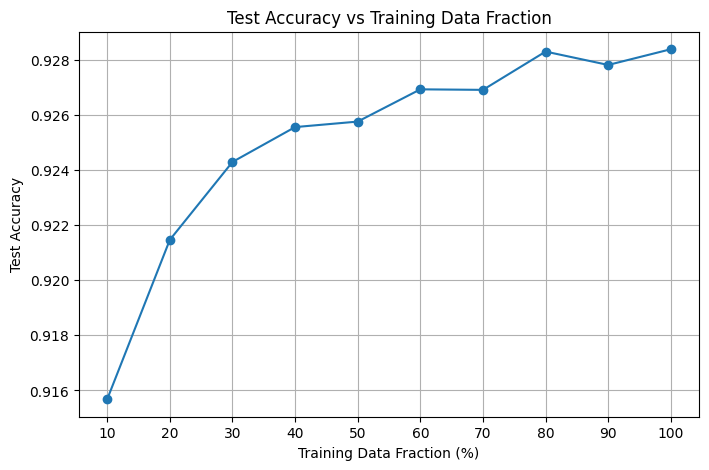

In [ ]:
# Cell 3: Plot accuracy vs training data fraction
fractions_percent = [int(f*100) for f in fractions]
accuracies = [acc for _, acc in results]

plt.figure(figsize=(8,5))
plt.plot(fractions_percent, accuracies, marker='o')
plt.title("Test Accuracy vs Training Data Fraction")
plt.xlabel("Training Data Fraction (%)")
plt.ylabel("Test Accuracy")
plt.xticks(fractions_percent)
plt.grid(True)
plt.show()
